## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from datetime import datetime, timedelta
from itertools import product
from scipy.stats import norm

## Binary outcome & simulation: Arithmetic betting & risk-of-ruin

### Binary game simulation function

In [2]:
# Sign function (lambda expression)
stepfunc = lambda x: 1 if x > 0 else 0


def getsimarr(base, perbet, p, b, numtrials, numsim=1000):
    """
    Obtain dictionary of simulation results in p = 0.5 setting.
    base: starting total capital (default $100)
    perbet: amount per bet (e.g. $20)
    p: winning probability
    numtrials: number of trials of the same binary game
    numsim: number of binary simulation
    """
    simdict = dict()
    amtdict = dict()
    for num in range(numsim):
        signarr = np.array([stepfunc(r) for r in np.random.uniform(p-1, p, numtrials)])
        trialarr = perbet * ((b + 1) * signarr - 1 )
        simdict[num] = trialarr 
        amtarr = base + trialarr.cumsum()
        betnum = 1
        while betnum <= numtrials - 1:
            if amtarr[betnum] < perbet:
                for j in range(betnum, numtrials):
                    amtarr[j] = amtarr[betnum]
                amtdict[f's{num}'] = amtarr
                break
            betnum += 1

        amtdict[f's{num}'] = amtarr    
    
    return simdict, amtdict

### Sample simulation: 20 trials, 30 simulations, converted into dataframe

In [3]:
base = 100  # Initial capital
perbet = 20  # Fixed amount per bet
p = 0.5   # winning probability
b = 1.25   # reward-risk ratio / odds
numtrials = 10 # Number of trials
numsim = 20  # Number of simulations (how many people keep playing same game for 10 runs)

pfactor = round(p * b / (1 - p), 4)  # profit factor
print(f'Profit Factor = {pfactor}')

simdict0, amtdict0 = getsimarr(base, perbet, p=p, b=b, numtrials=numtrials, numsim=20)

dfbet0 = pd.DataFrame(amtdict0).transpose()
dfbet0

Profit Factor = 1.25


,0,1,2,3,4,5,6,7,8,9
s0,125.0,105.0,85.0,65.0,90.0,115.0,95.0,120.0,100.0,80.0
s1,125.0,105.0,130.0,155.0,135.0,115.0,140.0,165.0,145.0,170.0
s2,80.0,105.0,85.0,65.0,90.0,70.0,95.0,120.0,145.0,125.0
s3,80.0,60.0,85.0,65.0,90.0,115.0,140.0,120.0,145.0,125.0
s4,80.0,60.0,40.0,65.0,90.0,115.0,140.0,120.0,145.0,125.0
s5,125.0,105.0,85.0,110.0,135.0,160.0,140.0,120.0,100.0,80.0
s6,80.0,105.0,130.0,110.0,90.0,115.0,140.0,165.0,190.0,215.0
s7,125.0,150.0,175.0,155.0,180.0,205.0,230.0,255.0,280.0,260.0
s8,80.0,60.0,85.0,110.0,135.0,115.0,140.0,165.0,145.0,170.0
s9,125.0,105.0,85.0,65.0,45.0,25.0,50.0,30.0,10.0,10.0


### Risk-of-ruin and 100 trials, 1000 simulations in sample case

In [4]:
numtrials = 100
numsim = 1000
p = 0.5   # winning probability
b = 1.25   # reward-risk ratio / odds
perbet = 10

simdict1, amtdict1 = getsimarr(base, perbet, p=p, b=b, numtrials=numtrials, numsim=numsim)
dfbet1 = pd.DataFrame(amtdict1).transpose()

ruin = dfbet1[dfbet1[numtrials - 1] <= perbet].shape[0] / dfbet1.shape[0]
print(f"Risk of ruin with unit bet {perbet}, p=0.5, b={b}, {numtrials} bets: {ruin}")

Risk of ruin with unit bet 10, p=0.5, b=1.25, 100 bets: 0.111


### Final performance KPI of 1000 simulations of a binary game 

In [5]:
def getsimkpi(base, perbet, p, b, numtrials, numsim):
    """Obtain a dictionary of final performance KPI of simulations. """
    simdict, amtdict = getsimarr(base, perbet, p, b, numtrials, numsim)
    dfbet = pd.DataFrame(amtdict).transpose()
    kpidict = dict()
    kpidict['ruin'] = round(dfbet[dfbet[numtrials - 1] <= perbet].shape[0] / dfbet.shape[0], 4)
    kpidict['win%'] = round(dfbet[dfbet[numtrials - 1] > base].shape[0] / dfbet.shape[0], 4)
    kpidict['P/Lavg'] = round(dfbet[numtrials - 1].mean() - base, 4)
    kpidict['P/Lstd'] = round(dfbet[numtrials - 1].std(), 4) 
    
    return dfbet, kpidict

In [6]:
dfbettest, kpidicttest = getsimkpi(100, 20, 0.5, 1.25, 104, 1000)
kpidicttest

{'ruin': 0.39, 'win%': 0.599, 'P/Lavg': 173.705, 'P/Lstd': 258.6422}

In [7]:
dfbettest, kpidicttest = getsimkpi(100, 10, 0.56, 1.44, 104, 1000)
kpidicttest

{'ruin': 0.011, 'win%': 0.989, 'P/Lavg': 377.9356, 'P/Lstd': 129.9717}

## Fixed p = 0.5, 104 bets (2 year), 1000 sims, varied perbet amount and odds

### Simulations

In [8]:
oddslist = [0.25 * r for r in range(2, 13)]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]
base = 100
p = 0.5
numtrials = 104
numsim = 1000

betdict = dict()
dfruin1 = pd.DataFrame(columns=oddslist, index=dollist)  # Risk of ruin
dfplus1 = pd.DataFrame(columns=oddslist, index=dollist)  # Terminal winning probability
dfamtavg1 = pd.DataFrame(columns=oddslist, index=dollist) # Average final P/L
dfamtstd1 = pd.DataFrame(columns=oddslist, index=dollist) # SD of final P/L
for odds, amt in product(oddslist, amtlist):
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin1.loc[f'${amt}', odds] = kpidict['ruin']
    dfplus1.loc[f'${amt}', odds] = kpidict['win%']
    dfamtavg1.loc[f'${amt}', odds] = kpidict['P/Lavg']
    dfamtstd1.loc[f'${amt}', odds] = kpidict['P/Lstd'] 

### Equity Curve plots: Profit factor 1.5, 10 per bet

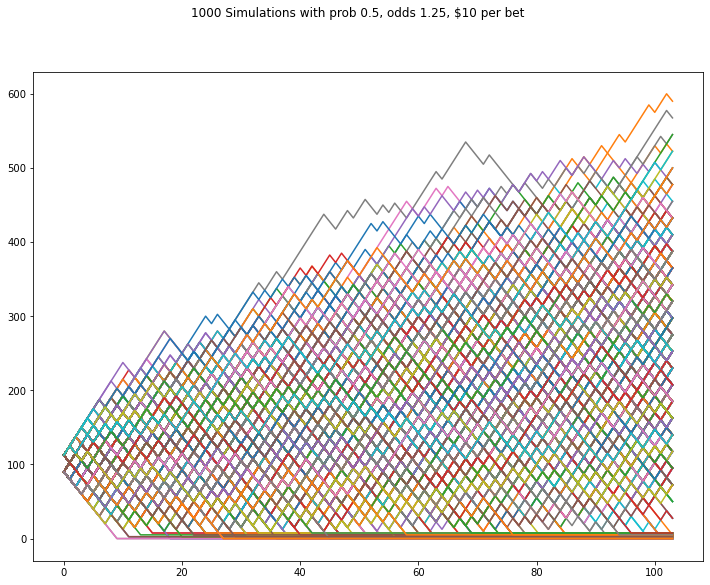

In [9]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 1.25, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

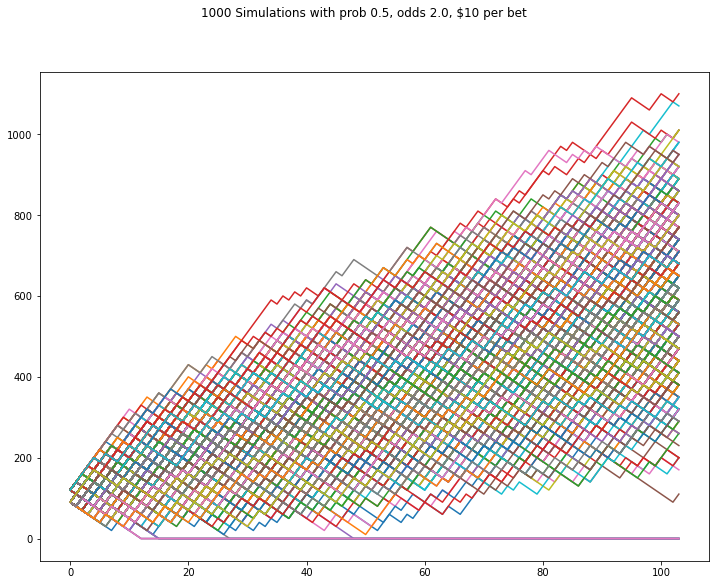

In [10]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 2.0, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

### Equity Curve plots: Profit factor 0.75, 10 per bet

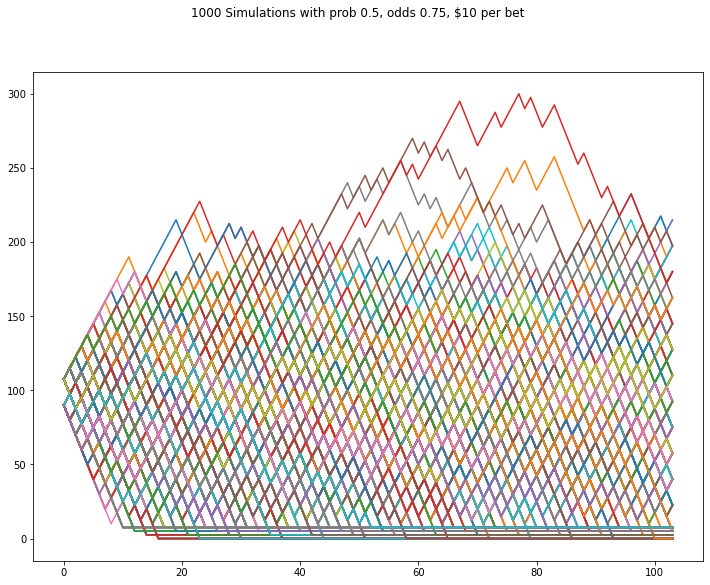

In [11]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 0.75, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

### Risk-of-ruin

In [12]:
dfruin1

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,1,0.958,0.699,0.45,0.283,0.22,0.144,0.128,0.113,0.103,0.082
$20,1,0.951,0.627,0.364,0.219,0.144,0.104,0.08,0.063,0.059,0.043
$12.5,0.998,0.861,0.421,0.19,0.085,0.044,0.014,0.019,0.012,0.01,0.007
$10,0.993,0.775,0.33,0.115,0.048,0.013,0.008,0.006,0.007,0.007,0.001
$8,0.983,0.676,0.235,0.067,0.018,0.005,0.001,0.001,0.001,0,0
$5,0.861,0.297,0.049,0.004,0.001,0,0,0,0,0,0
$4,0.649,0.132,0.014,0.002,0,0,0,0,0,0,0
$3,0.22,0.021,0.004,0,0,0,0,0,0,0,0
$2,0.003,0,0,0,0,0,0,0,0,0,0
$1,0,0,0,0,0,0,0,0,0,0,0


In [13]:
dfruin1[(dfruin1 <= 0.01) & (dfamtavg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.007
$10,NaN,NaN,NaN,NaN,NaN,NaN,0.008,0.006,0.007,0.007,0.001
$8,NaN,NaN,NaN,NaN,NaN,0.005,0.001,0.001,0.001,0,0
$5,NaN,NaN,NaN,0.004,0.001,0,0,0,0,0,0
$4,NaN,NaN,NaN,0.002,0,0,0,0,0,0,0
$3,NaN,NaN,NaN,0,0,0,0,0,0,0,0
$2,NaN,NaN,NaN,0,0,0,0,0,0,0,0
$1,NaN,NaN,0,0,0,0,0,0,0,0,0


### Probability of terminal winning 

In [14]:
dfplus1

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,0,0.032,0.272,0.545,0.717,0.78,0.856,0.872,0.887,0.897,0.918
$20,0,0.03,0.325,0.628,0.779,0.856,0.896,0.92,0.937,0.941,0.957
$12.5,0,0.066,0.432,0.775,0.91,0.955,0.986,0.981,0.988,0.99,0.993
$10,0,0.069,0.46,0.824,0.948,0.986,0.992,0.994,0.993,0.993,0.999
$8,0,0.073,0.471,0.842,0.973,0.995,0.999,0.998,0.999,1,1
$5,0,0.074,0.467,0.859,0.978,0.997,1,1,1,1,1
$4,0,0.07,0.476,0.851,0.97,0.995,1,1,1,1,1
$3,0,0.062,0.462,0.863,0.975,0.999,1,1,1,1,1
$2,0,0.063,0.445,0.861,0.981,0.998,0.999,1,1,1,1
$1,0,0.074,0.471,0.862,0.973,0.996,1,1,1,1,1


In [15]:
dfplus1[(dfruin1 <= 0.01) & (dfamtavg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99,0.993
$10,NaN,NaN,NaN,NaN,NaN,NaN,0.992,0.994,0.993,0.993,0.999
$8,NaN,NaN,NaN,NaN,NaN,0.995,0.999,0.998,0.999,1,1
$5,NaN,NaN,NaN,0.859,0.978,0.997,1,1,1,1,1
$4,NaN,NaN,NaN,0.851,0.97,0.995,1,1,1,1,1
$3,NaN,NaN,NaN,0.863,0.975,0.999,1,1,1,1,1
$2,NaN,NaN,NaN,0.861,0.981,0.998,0.999,1,1,1,1
$1,NaN,NaN,0.471,0.862,0.973,0.996,1,1,1,1,1


### Average Terminal P/L

In [16]:
dfamtavg1[(dfruin1 <= 0.01) & (dfamtavg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125.97,1309.1
$10,NaN,NaN,NaN,NaN,NaN,NaN,511.11,639.64,778.835,900.825,1037.9
$8,NaN,NaN,NaN,NaN,NaN,315.966,415.44,520.188,629.384,723.17,833.024
$5,NaN,NaN,NaN,63.9875,129.195,197.984,263.135,326.576,391.225,453.856,516.66
$4,NaN,NaN,NaN,51.394,104.18,155.934,210.484,260.533,318.23,364.87,416.096
$3,NaN,NaN,NaN,38.2643,76.59,116.233,155.379,193.508,233.57,271.223,310.74
$2,NaN,NaN,NaN,26.3555,50.965,79.3255,103.4,129.188,155.538,179.105,210.632
$1,NaN,NaN,0.266,12.982,25.42,38.1695,51.895,66.3618,77.692,90.4487,104.028


### SD of  Terminal P/L (positive skew due to extreme winners)

In [17]:
dfamtstd1

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,6.0765,38.4749,181.31,322.54,439.964,555.588,610.13,690.121,776.25,855.417,889.693
$20,4.8612,36.4656,156.663,263.664,334.964,406.313,454.418,489.343,529.798,578.127,607.488
$12.5,3.624,41.6692,116.626,156.529,186.689,209.834,208.271,238.925,253.108,273.203,283.73
$10,5.4025,39.5966,93.0127,121.033,139.962,150.572,160.815,177.661,194.605,209.012,206.41
$8,4.7855,39.775,78.5591,97.1652,107.984,113.266,124.076,140.484,148.971,157.042,165.554
$5,11.1822,36.7129,52.2791,55.9451,65.5099,68.9519,74.7689,82.2501,88.1529,95.7745,99.7717
$4,15.5889,33.3885,40.6599,47.7638,52.3327,56.4508,62.6458,67.9574,71.0902,75.7703,81.5214
$3,20.1233,26.6123,31.7345,34.3262,39.1309,42.3834,46.1995,50.2424,53.8699,56.5734,62.3341
$2,15.7513,17.7744,19.9907,23.1184,25.1224,27.6,30.4796,33.9002,35.8725,38.9162,40.376
$1,7.4903,8.9631,10.2781,11.768,13.1115,14.1011,15.8716,16.7758,17.6914,19.1196,20.6384


## Fixed odds = 1, 104 bets (2 year), 1000 sims, varied perbet amount and odds

### Simulations

In [18]:
base = 100
odds = 1
problist = [pf / (pf + odds) for pf in np.arange(0.5, 3.25, 0.25)]
probcollist = [f'{round(100 * prob, 1)}%' for prob in problist]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]
numtrials = 104
numsim = 1000

dfruin2 = pd.DataFrame(columns=probcollist, index=dollist)  # Risk of ruin
dfplus2 = pd.DataFrame(columns=probcollist, index=dollist)  # Terminal winning probability
dfamtavg2 = pd.DataFrame(columns=probcollist, index=dollist) # Average final P/L
dfamtstd2 = pd.DataFrame(columns=probcollist, index=dollist) # SD of final P/L

for p, amt in product(problist, amtlist):
    prob = round(100 * p, 1)
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin2.loc[f'${amt}', f'{prob}%'] = kpidict['ruin']
    dfplus2.loc[f'${amt}', f'{prob}%'] = kpidict['win%']
    dfamtavg2.loc[f'${amt}', f'{prob}%'] = kpidict['P/Lavg']
    dfamtstd2.loc[f'${amt}', f'{prob}%'] = kpidict['P/Lstd']


### Equity curve Plots (profit factor 2.0, 10 per bet)

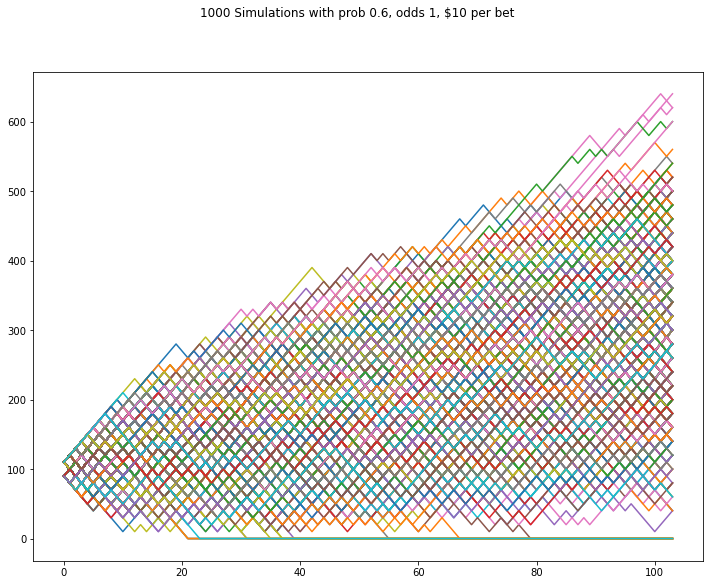

In [19]:
fig = plt.figure(figsize=(12, 9))
spec = (0.6, 1, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

### Risk-of-ruin

In [20]:
dfruin2

,33.3%,42.9%,50.0%,55.6%,60.0%,63.6%,66.7%,69.2%,71.4%,73.3%,75.0%
$25,1,0.954,0.709,0.407,0.19,0.097,0.074,0.037,0.02,0.012,0.011
$20,1,0.942,0.641,0.305,0.129,0.052,0.027,0.014,0.012,0.008,0.006
$12.5,0.999,0.885,0.418,0.127,0.038,0.011,0.004,0.004,0,0,0
$10,0.998,0.82,0.329,0.096,0.014,0.002,0.002,0,0,0,0
$8,0.998,0.747,0.247,0.043,0.006,0,0,0,0,0,0
$5,0.959,0.418,0.051,0.001,0,0,0,0,0,0,0
$4,0.899,0.222,0.013,0.001,0,0,0,0,0,0,0
$3,0.625,0.056,0.001,0,0,0,0,0,0,0,0
$2,0.076,0,0,0,0,0,0,0,0,0,0
$1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
dfruin2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

,33.3%,42.9%,50.0%,55.6%,60.0%,63.6%,66.7%,69.2%,71.4%,73.3%,75.0%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008,0.006
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,0.004,0.004,0,0,0
$10,NaN,NaN,NaN,NaN,NaN,0.002,0.002,0,0,0,0
$8,NaN,NaN,NaN,NaN,0.006,0,0,0,0,0,0
$5,NaN,NaN,NaN,0.001,0,0,0,0,0,0,0
$4,NaN,NaN,NaN,0.001,0,0,0,0,0,0,0
$3,NaN,NaN,NaN,0,0,0,0,0,0,0,0
$2,NaN,NaN,NaN,0,0,0,0,0,0,0,0
$1,NaN,NaN,0,0,0,0,0,0,0,0,0


### Probability of terminal winning 

In [22]:
dfplus2

,33.3%,42.9%,50.0%,55.6%,60.0%,63.6%,66.7%,69.2%,71.4%,73.3%,75.0%
$25,0,0.031,0.257,0.585,0.805,0.901,0.926,0.963,0.98,0.988,0.989
$20,0,0.031,0.3,0.675,0.87,0.947,0.973,0.986,0.988,0.992,0.994
$12.5,0,0.051,0.429,0.795,0.951,0.988,0.995,0.996,1,1,1
$10,0,0.064,0.434,0.832,0.966,0.995,0.998,1,1,1,1
$8,0,0.042,0.452,0.839,0.969,0.993,1,1,1,1,1
$5,0,0.055,0.459,0.836,0.977,0.996,0.998,1,1,1,1
$4,0.001,0.062,0.471,0.855,0.974,0.998,1,1,1,1,1
$3,0.001,0.061,0.473,0.856,0.978,0.998,1,1,1,1,1
$2,0,0.062,0.448,0.837,0.98,0.995,1,1,1,1,1
$1,0,0.061,0.46,0.839,0.975,0.996,0.999,1,1,1,1


In [23]:
dfplus2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

,33.3%,42.9%,50.0%,55.6%,60.0%,63.6%,66.7%,69.2%,71.4%,73.3%,75.0%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992,0.994
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,0.995,0.996,1,1,1
$10,NaN,NaN,NaN,NaN,NaN,0.995,0.998,1,1,1,1
$8,NaN,NaN,NaN,NaN,0.969,0.993,1,1,1,1,1
$5,NaN,NaN,NaN,0.836,0.977,0.996,0.998,1,1,1,1
$4,NaN,NaN,NaN,0.855,0.974,0.998,1,1,1,1,1
$3,NaN,NaN,NaN,0.856,0.978,0.998,1,1,1,1,1
$2,NaN,NaN,NaN,0.837,0.98,0.995,1,1,1,1,1
$1,NaN,NaN,0.46,0.839,0.975,0.996,0.999,1,1,1,1


### Average Terminal P/L

In [24]:
dfamtavg2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

,33.3%,42.9%,50.0%,55.6%,60.0%,63.6%,66.7%,69.2%,71.4%,73.3%,75.0%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,962.44,1026.88
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,429.2,497.975,555.95,607.35,648.975
$10,NaN,NaN,NaN,NaN,NaN,284.66,343.38,401.94,450.92,490.26,517.44
$8,NaN,NaN,NaN,NaN,164.832,229.376,280.256,318.832,358.432,388.032,416.24
$5,NaN,NaN,NaN,56.41,102.82,143.22,174.5,199.76,223.13,242.38,260.42
$4,NaN,NaN,NaN,45.78,83.392,113.784,138.344,160.936,175.92,194.232,209.36
$3,NaN,NaN,NaN,33.75,63.366,85.65,104.376,121.278,134.82,145.296,157.566
$2,NaN,NaN,NaN,23,42.028,57.72,68.588,80.504,89.82,97.184,104.096
$1,NaN,NaN,0.29,11.666,20.194,28.084,34.158,39.448,44.7,48.774,52.06


### SD Terminal P/L

In [25]:
dfamtstd2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

,33.3%,42.9%,50.0%,55.6%,60.0%,63.6%,66.7%,69.2%,71.4%,73.3%,75.0%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.974,189.396
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,126.628,127.088,111.93,111.179,108.663
$10,NaN,NaN,NaN,NaN,NaN,101.225,97.9233,94.0036,92.7003,93.4659,91.9843
$8,NaN,NaN,NaN,NaN,79.7366,81.1167,78.5041,75.5362,74.9175,69.6863,71.1533
$5,NaN,NaN,NaN,51.1001,49.5126,48.4001,49.4489,48.1608,46.5711,45.5677,45.6235
$4,NaN,NaN,NaN,40.2389,39.584,38.8002,38.1558,39.7045,35.8575,34.875,34.7111
$3,NaN,NaN,NaN,29.3082,29.2367,30.0794,28.2123,28.5932,26.6679,26.4632,26.6772
$2,NaN,NaN,NaN,20.9781,19.9097,19.4775,19.4233,18.3159,17.9752,18.2591,18.2455
$1,NaN,NaN,10.3214,10.346,10.365,10.0633,9.4372,9.171,9.1718,8.9087,8.6278


## Fixed Profit Factor = 1.5, 104 bets, varied prob & per bet 

In [26]:
oddslist = [0.25 * r for r in range(2, 13)]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]

base = 100
numtrials = 104
numsim = 1000
pfactor = 1.5

dfruin3 = pd.DataFrame(columns=oddslist, index=dollist)
dfplus3 = pd.DataFrame(columns=oddslist, index=dollist)
dfamtavg3 = pd.DataFrame(columns=oddslist, index=dollist)
dfamtstd3 = pd.DataFrame(columns=oddslist, index=dollist)


for odds, amt in product(oddslist, amtlist):
    p = pfactor / (odds + pfactor)
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin3.loc[f'${amt}', odds] = kpidict['ruin']
    dfplus3.loc[f'${amt}', odds] = kpidict['win%']  
    dfamtavg3.loc[f'${amt}', odds] = kpidict['P/Lavg'] 
    dfamtstd3.loc[f'${amt}', odds] = kpidict['P/Lstd'] 

### Risk-of-ruin

In [27]:
dfruin3

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,0.147,0.196,0.189,0.255,0.283,0.339,0.316,0.386,0.407,0.429,0.419
$20,0.088,0.125,0.114,0.18,0.219,0.261,0.273,0.302,0.318,0.348,0.346
$12.5,0.011,0.032,0.036,0.066,0.077,0.107,0.114,0.12,0.168,0.181,0.182
$10,0.007,0.01,0.019,0.031,0.042,0.049,0.051,0.071,0.094,0.103,0.105
$8,0,0.005,0.008,0.01,0.018,0.029,0.039,0.034,0.054,0.072,0.084
$5,0,0,0,0.001,0.001,0.004,0.003,0.005,0.007,0.01,0.012
$4,0,0,0,0,0,0.001,0,0.003,0.004,0.002,0.005
$3,0,0,0,0,0,0,0,0.001,0,0,0.001
$2,0,0,0,0,0,0,0,0,0,0,0
$1,0,0,0,0,0,0,0,0,0,0,0


In [28]:
dfruin3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$8,0,0.005,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$5,0,0,0,0.001,0.001,0.004,0.003,0.005,0.007,NaN,NaN
$4,0,0,0,0,0,0.001,0,0.003,0.004,0.002,0.005
$3,0,0,0,0,0,0,0,0.001,0,0,0.001
$2,0,0,0,0,0,0,0,0,0,0,0
$1,0,0,0,0,0,0,0,0,0,0,0


### Terminal winning probabilities

In [29]:
dfplus3

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,0.844,0.802,0.809,0.742,0.717,0.661,0.684,0.614,0.593,0.571,0.579
$20,0.91,0.87,0.877,0.818,0.778,0.739,0.726,0.694,0.681,0.652,0.65
$12.5,0.962,0.958,0.954,0.923,0.915,0.89,0.884,0.872,0.828,0.817,0.808
$10,0.972,0.976,0.971,0.96,0.952,0.945,0.942,0.919,0.895,0.888,0.888
$8,0.976,0.981,0.973,0.975,0.972,0.963,0.95,0.945,0.936,0.923,0.9
$5,0.964,0.973,0.972,0.979,0.991,0.975,0.972,0.968,0.962,0.968,0.964
$4,0.978,0.982,0.965,0.978,0.986,0.983,0.979,0.955,0.973,0.973,0.952
$3,0.967,0.983,0.969,0.974,0.987,0.98,0.979,0.964,0.969,0.965,0.951
$2,0.969,0.975,0.975,0.973,0.98,0.979,0.98,0.967,0.975,0.97,0.954
$1,0.969,0.982,0.978,0.98,0.975,0.979,0.98,0.963,0.974,0.971,0.959


### Average Terminal P/L

In [30]:
dfamtavg3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,129.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$8,104.588,136.168,161.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$5,64.685,86.7075,104.06,118.569,130.423,139.491,151.595,159.201,160.83,NaN,NaN
$4,52.69,69.24,80.496,94.84,105.09,111.832,116.092,122.92,129.24,135.509,136.908
$3,38.4195,51.846,60.666,70.2053,78.9375,83.9917,91.875,93.3855,96.3975,100.222,104.097
$2,26.297,34.627,40.948,47.195,52.16,56.66,59.864,62.244,64.209,64.4675,71.104
$1,13.1575,17.4167,20.936,23.5727,25.825,28.0248,29.98,31.4762,31.1175,34.2925,34.692


### SD Terminal P/L

In [31]:
dfamtstd3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,66.9606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$8,51.5848,66.2083,79.8674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$5,34.1831,42.3912,51.3045,59.0808,60.8762,72.6709,80.1989,82.009,89.9511,NaN,NaN
$4,26.3009,33.2379,40.8707,45.5848,51.1227,54.8701,58.1328,66.8997,68.9361,73.3656,78.3761
$3,20.733,25.2222,29.3206,34.8613,37.3905,41.9996,45.2555,50.669,51.8048,55.8373,58.6205
$2,13.3711,16.8442,20.3775,22.9058,25.8581,28.8596,29.9689,32.9441,35.2452,36.1388,39.1505
$1,6.6084,8.2811,9.9884,11.3459,13.3711,14.0883,15.1902,16.4783,16.949,18.3846,18.8401


## Fixed winrate p and odds b, varied number of trials & bet amount

In [32]:
numsim = 1000
base = 100
p = 0.54
b = 1.56
pfactor = b*p / (1 - p)
print(f'Profit Factor = {pfactor}')
triallist = list(range(50, 300, 50))
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]

dfruin4 = pd.DataFrame(columns=triallist, index=dollist)
dfplus4 = pd.DataFrame(columns=triallist, index=dollist)
dfamtavg4 = pd.DataFrame(columns=triallist, index=dollist)
dfamtstd4 = pd.DataFrame(columns=triallist, index=dollist)

for numtrial, amt in product(triallist, amtlist):
    dfbet, kpidict = getsimkpi(base, amt, p, b, numtrial, numsim)
    dfruin4.loc[f'${amt}', numtrial] = kpidict['ruin']
    dfplus4.loc[f'${amt}', numtrial] = kpidict['win%']  
    dfamtavg4.loc[f'${amt}', numtrial] = kpidict['P/Lavg'] 
    dfamtstd4.loc[f'${amt}', numtrial] = kpidict['P/Lstd'] 

### Risk-of-ruin

In [34]:
dfruin4

,50,100,150,200,250
$25,0.153,0.162,0.183,0.167,0.18
$20,0.097,0.105,0.1,0.102,0.103
$12.5,0.023,0.026,0.023,0.028,0.017
$10,0.01,0.012,0.006,0.011,0.012
$8,0,0.005,0.001,0.004,0
$5,0,0,0,0,0
$4,0,0,0,0,0
$3,0,0,0,0,0
$2,0,0,0,0,0
$1,0,0,0,0,0


### Terminal winning probabilities

In [36]:
dfplus4[dfruin4 < 0.01]

,50,100,150,200,250
$25,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,0.994,NaN,NaN
$8,0.98,0.994,0.999,0.996,1
$5,0.983,0.998,1,1,1
$4,0.972,0.997,1,1,1
$3,0.983,0.998,1,1,1
$2,0.979,0.998,1,1,1
$1,0.984,0.997,1,1,1


### Average Terminal P/L

In [37]:
dfamtavg4[(dfruin4 < 0.01)]

,50,100,150,200,250
$25,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN
$12.5,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,570.646,NaN,NaN
$8,152.673,300.862,462.237,612.267,753.905
$5,94.4736,190.496,288.733,379.84,479.587
$4,74.4832,153.554,229.215,303.36,381.366
$3,57.3446,114.958,170.651,228.657,288.228
$2,37.4771,76.6643,112.861,153.431,192.301
$1,19.4938,37.9072,57.081,76.7718,94.6554
